In [1]:
import os
import torch
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Resize

from active_gym.atari_env import AtariFixedFovealEnv, AtariEnvArgs
from agent.dqn_atari_sugarl import QNetwork
from common.pvm_buffer import PVMBuffer

/home/stalhand/miniconda3/envs/arl/lib/python3.9/site-packages/glfw/__init__.py:917: GLFWError: (65550) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


Robosuite loading error. Ignore this if you do not use robosuite.
RLBench loding error. Ignore this if you do not use RLBench.


In [13]:
resize = Resize((84, 84))

In [4]:
env_args = AtariEnvArgs(
    game="pong",
    seed=0,
    obs_size=(84, 84),
    fov_size=(50, 50),
    fov_init_loc=(0, 0),
    sensory_action_mode="absolute",
    sensory_action_space=(-10, 10),
    resize_to_full=True,
    clip_reward=True,
    record=False,
    mask_out=True,
)
env = AtariFixedFovealEnv(env_args)

# Wrap the env into a vectorized environment
vector_env = gym.vector.SyncVectorEnv([lambda: env])

In [7]:
from itertools import product
"""
OBSERVATION_SIZE = (84, 84)
fov_size = 50
x_size = 4
y_size = 4

observ_x_max = OBSERVATION_SIZE[0] - fov_size
observ_y_max = OBSERVATION_SIZE[1] - fov_size

step_x = observ_x_max // x_size
step_y = observ_y_max // y_size

x_set = list(range(0, observ_x_max, step_x))[:x_size]
y_set = list(range(0, observ_y_max, step_y))[:y_size]

sensory_action_set = [np.array(a) for a in product(x_set, y_set)]
"""

In [19]:
# Step 0: Reconstruct sensory action set (same logic as in training)
fov_size = 50
obs_size = 84
x_size, y_size = 4, 4  # Must match training args

observ_x_max = obs_size - fov_size
observ_y_max = obs_size - fov_size
step_x = observ_x_max // x_size
step_y = observ_y_max // y_size

x_coords = list(range(0, observ_x_max, step_x))[:x_size]
y_coords = list(range(0, observ_y_max, step_y))[:y_size]
sensory_action_set = [np.array([x, y]) for x, y in product(x_coords, y_coords)]

In [9]:
# === Load checkpoint ===
model_path = "trained_models/pong_3M_50x50/dqn_atari_sugarl/pong/pong_seed0_step3000000_model.pt"

checkpoint = torch.load(model_path, map_location="cpu")
model = QNetwork(vector_env, sensory_action_set=sensory_action_set)  # If needed, update to pass the sensory set
model.load_state_dict(checkpoint["q"])
model.eval()

QNetwork(
  (backbone): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
  )
  (motor_action_head): Linear(in_features=512, out_features=6, bias=True)
  (sensory_action_head): Linear(in_features=512, out_features=16, bias=True)
)

In [ ]:
# === Run one episode ===
obs, _ = env.reset()
pvm = PVMBuffer(3, (1, 4, 84, 84))
pvm = PVMBuffer(3, (4, 84, 84))  # no batch dimension here
done = False

while not done:
    pvm.append(obs)
    input_obs = resize(torch.from_numpy(pvm.get_obs(mode="stack_max"))).unsqueeze(0).float()
    with torch.no_grad():
        motor_q, sensory_q = model(input_obs)
        motor_action = motor_q.argmax().item()
        sensory_action = sensory_q.argmax().item()  # For now: assume sensory_action_space is continuous

    action = {
        "motor_action": motor_action,
        "sensory_action": np.array([0, 0])  # Replace with your logic if using discrete set
    }
    obs, reward, done, truncated, info = env.step(action)

    # === Visualization ===
    frame = obs[0]  # Assume grayscale stacked frames
    plt.imshow(frame, cmap="gray")
    plt.title("Foveated Observation")
    plt.axis("off")
    plt.pause(0.05)

plt.show()
env.close()

(4, 84, 84)
0.0 0.0


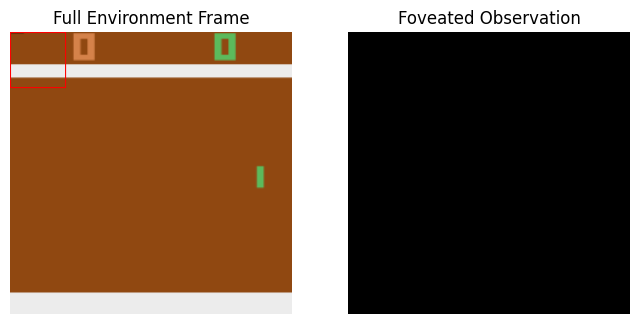

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.0


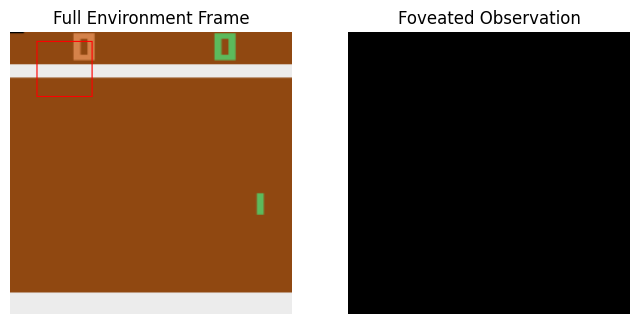

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.34117648005485535


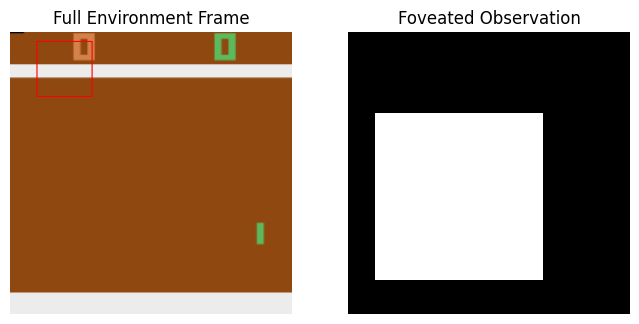

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.34117648005485535


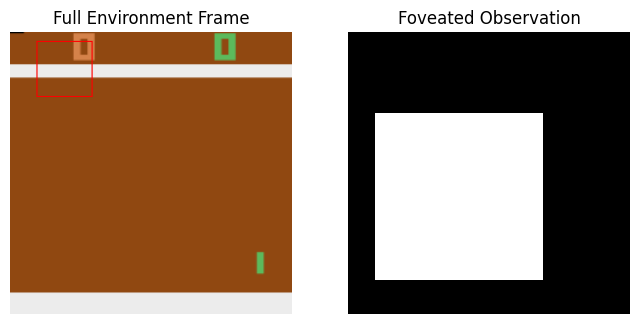

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.34117648005485535


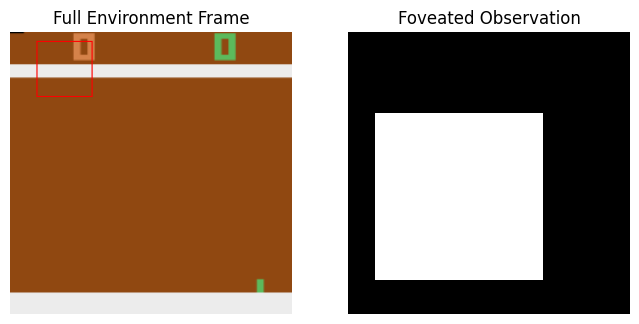

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.34117648005485535


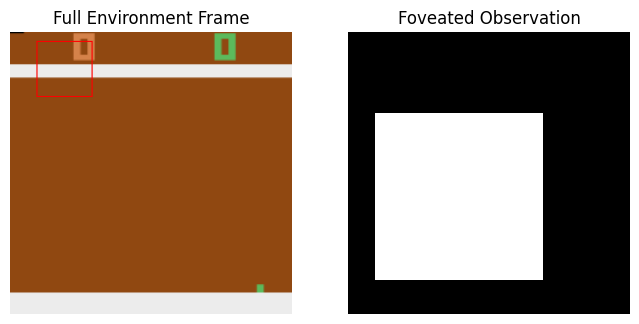

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.34117648005485535


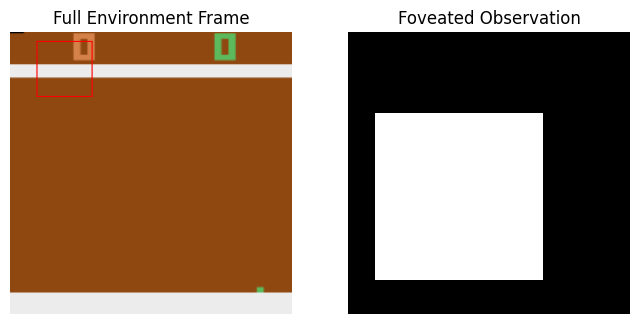

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.34117648005485535


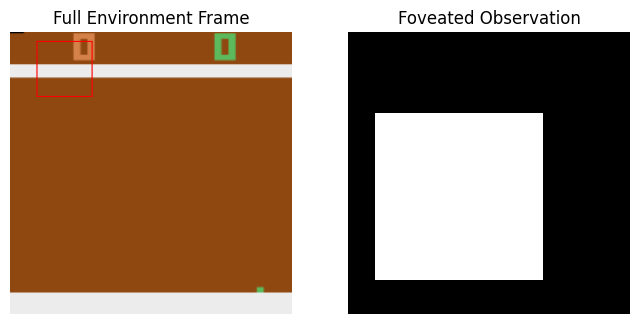

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.34117648005485535


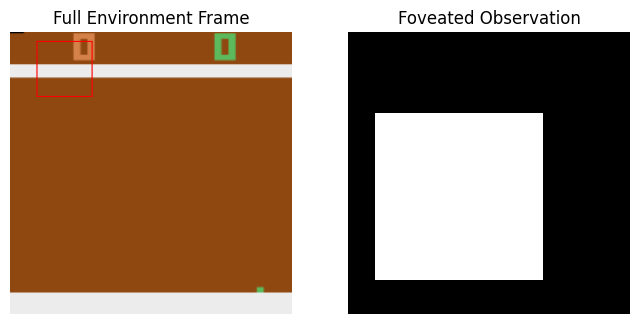

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.34117648005485535


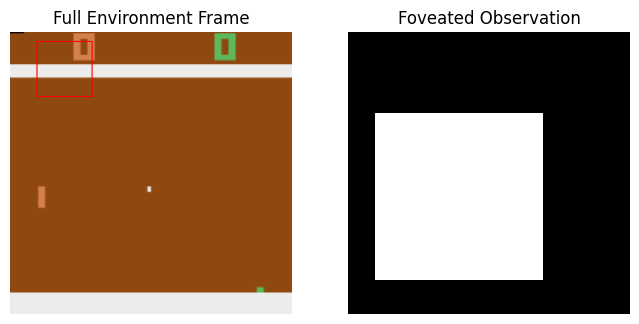

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.34117648005485535


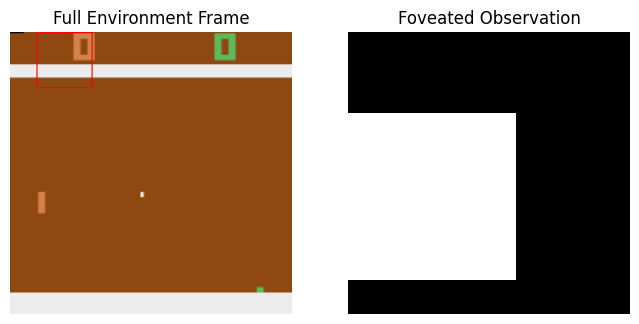

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.34117648005485535


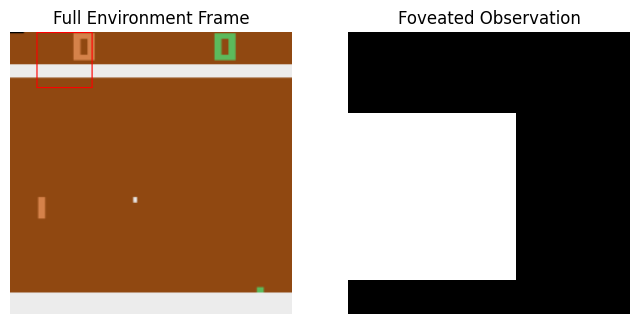

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.9254902005195618


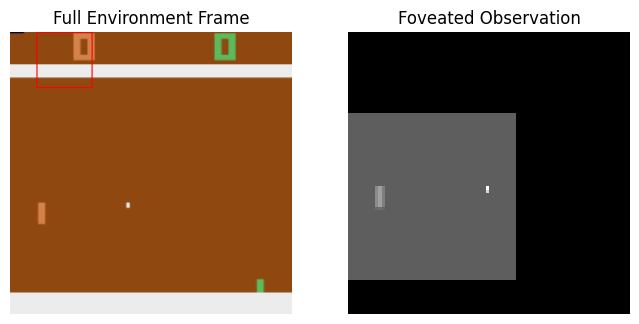

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.9254902005195618


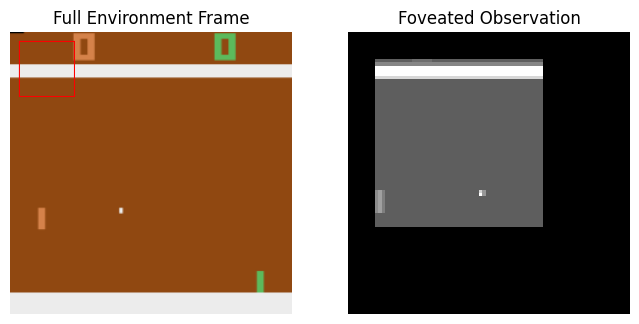

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.9254902005195618


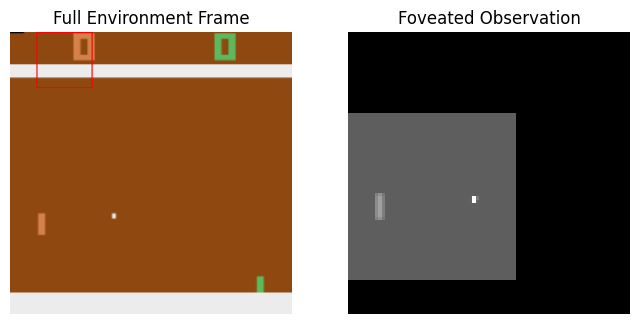

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.9254902005195618


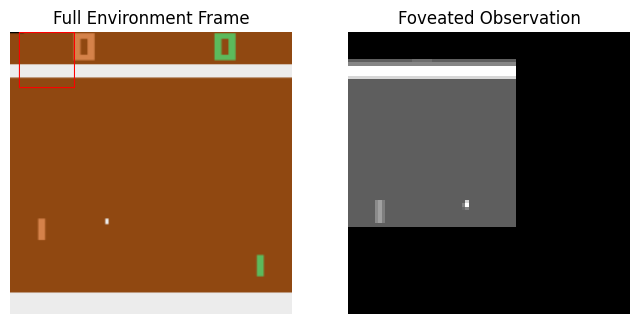

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.9254902005195618


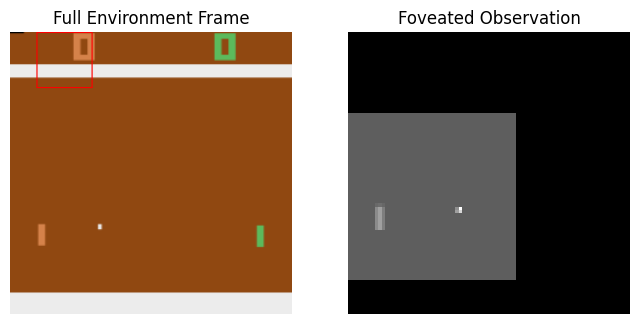

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.9254902005195618


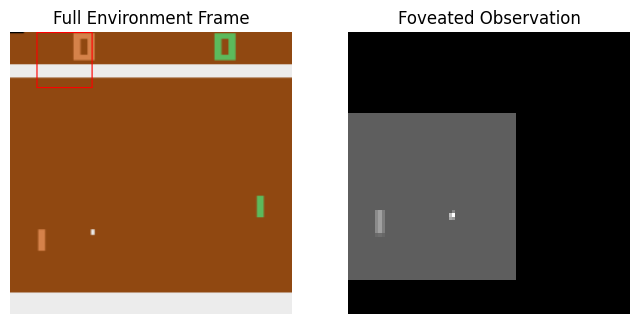

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.9254902005195618


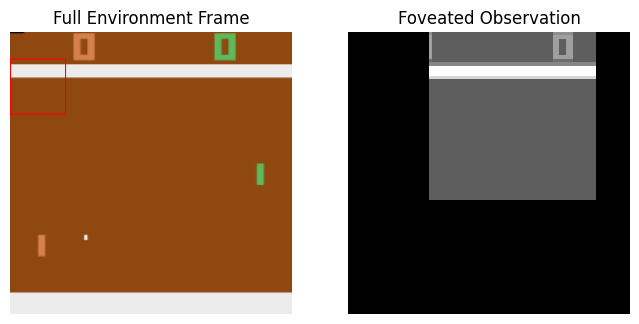

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.9254902005195618


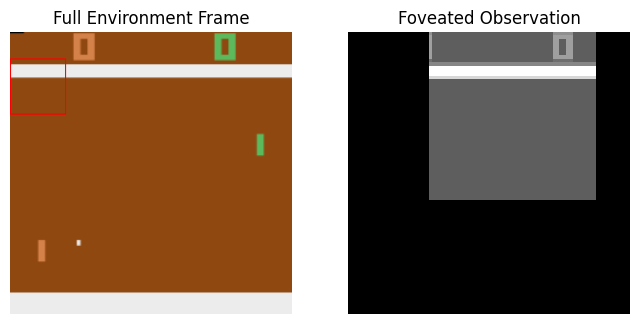

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.9254902005195618


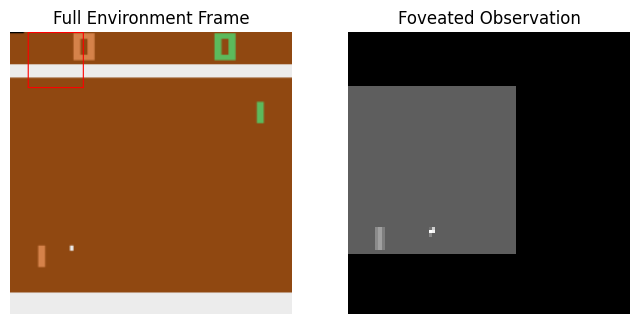

<Figure size 640x480 with 0 Axes>

(4, 84, 84)
0.0 0.4588235318660736


KeyboardInterrupt: 

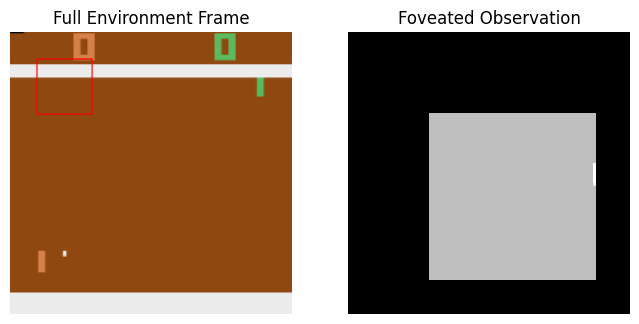

In [28]:
# === Run one episode ===
obs, _ = env.reset()
pvm = PVMBuffer(3, (1, 4, 84, 84))
pvm = PVMBuffer(3, (4, 84, 84))  # no batch dimension here
done = False

import cv2

# Unwrap the base environment to get the original frame
base_env = env.env.env  # May require more `.env` depending on wrappers

while not done:
    pvm.append(obs)
    input_obs = resize(torch.from_numpy(pvm.get_obs(mode="stack_max"))).unsqueeze(0).float()
    """
    with torch.no_grad():
        motor_q, sensory_q = model(input_obs)
        motor_action = motor_q.argmax().item()
        sensory_action = sensory_q.argmax().item()  # For now: assume sensory_action_space is continuous

    action = {
        "motor_action": motor_action,
        "sensory_action": np.array([0, 0])  # Replace with your logic if using discrete set
    }
    """
    # Predict actions
    with torch.no_grad():
        motor_q, sensory_q = model(input_obs)
        motor_action = motor_q.argmax().item()
        sensory_action_idx = sensory_q.argmax().item()

    # Lookup the 2D fovea position
    fovea_loc = sensory_action_set[sensory_action_idx]

    action = {
        "motor_action": motor_action,
        "sensory_action": fovea_loc
    }

    obs, reward, done, truncated, info = env.step(action)

    # === Visualization ===
    frame = obs[0]  # foveated + peripheral stacked observation (first channel)
    print(obs.shape)
    print(np.min(frame), np.max(frame))
    #print(frame)
    #full_frame = info.get("frame", np.zeros((84, 84)))  # fallback if key is missing
    full_frame = base_env.render(mode="rgb_array")

    # Display side by side
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(full_frame, cmap="gray")
    axs[0].set_title("Full Environment Frame")
    axs[0].axis("off")

    """
    x, y = fovea_loc
    w, h = fov_size, fov_size
    frame_with_box = full_frame.copy()
    cv2.rectangle(frame_with_box, (x, y), (x + w, y + h), (255, 0, 0), 1)
    axs[0].imshow(frame_with_box)
    """

    # full_frame: e.g., shape (H, W, 3)
    render_h, render_w = full_frame.shape[:2]

    # obs_size = 84, fov_size = 50
    scale_x = render_w / 84
    scale_y = render_h / 84

    # Scale the fovea coordinates and size
    x, y = fovea_loc
    w, h = fov_size, fov_size
    x_scaled = int(x * scale_x)
    y_scaled = int(y * scale_y)
    w_scaled = int(w * scale_x)
    h_scaled = int(h * scale_y)

    frame_with_box = full_frame.copy()
    cv2.rectangle(frame_with_box, (x_scaled, y_scaled), (x_scaled + w_scaled, y_scaled + h_scaled), (255, 0, 0), 2)
    axs[0].imshow(frame_with_box)

    axs[1].imshow(frame, cmap="gray")
    axs[1].set_title("Foveated Observation")
    axs[1].axis("off")

    plt.pause(0.05)
    plt.clf()  # clear figure to update next frame

    plt.show()
env.close()